# **Inferencia estadística**
# IE07. Caso práctico del TLC con Montecarlo

## <font color='blue'>__Bibliografía__</font>
* Applied Statistics and Probability for Engineers. Douglas C. Montgomery, George C. Runger, 2013.

* Essentials of Monte Carlo Simulation: Statistical Methods for Building Simulation Models. Nick T. Thomopoulos , 2013.

* Métodos Monte Carlo. Jose Ignacio Illana, Universidad de Granada, 2013.


## <font color='blue'>__Lecturas__</font>
* Raychaudhuri, S. (2008). Introduction to monte carlo simulation. In 2008 Winter simulation conference (pp. 91-100). IEEE.

* Jueeli Thete (2022). Understanding Monte Carlo Simulation and its implementation with Python. [Medium.com](https://medium.com/@juee_thete/understanding-monte-carlo-simulation-and-its-implementation-with-python-3ecacb958cd4)

## <font color='blue'>**Ejemplo del uso de TLC con simulación Montecarlo**</font>

Imagina que que disponemos de la historia de producción diaria de una organización. Veamos algunos ejemplos:
* Datos históricos de fabricación de piezas de repuestos para camiones mineros (producción física en unidades/semana).
* Datos de la cantidad de ventas de entradas para eventos (servicio online en entradas_vendidas/hora).
* Tenemos la velocidad de trabajo de un equipo ágil; la misma la medimos en Historias de usuario / sprint.

__Nota:__
Para la simulación de Montecarlo, se recomienda disponer de al menos 10 datos de historia. No podemos desarrollarla adecuadamente con, por ejemplo, 2 datos!!

Lectura adicional de [Montecarlo](https://es.wikipedia.org/wiki/M%C3%A9todo_de_Montecarlo)

Partamos cargando las librerías necesarias.


In [16]:
#Importamos librerias
import random
import numpy as np # importando numpy
import math
import matplotlib.pyplot as plt
import seaborn as sns

Vamos a tomar el ejemplo de la fábrica de piezas de repuestos para camiones mineros. Asumiremos que disponemos de datos de 10 semanas de producción. La unidad de medida de los mimos es ``piezas/semana``. Las piezas se fabrican en un taller y no son todas iguales; por eso se fabrican pocas por semana.


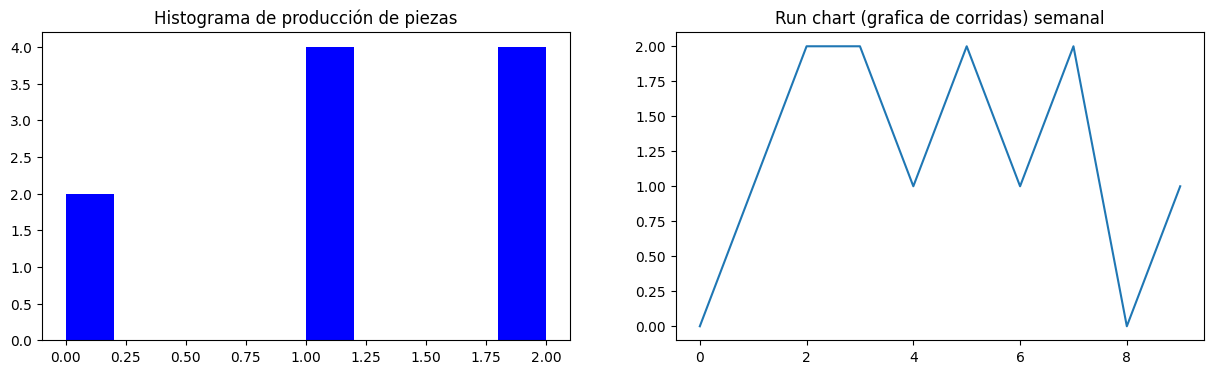


Tamaño muestra:  10
Media:  1.2
Desviación estándar:  2.37


In [17]:
# Ingresar velocidad de produccion por por ciclo (semana)
# En este ejemplo tenemos historia de 10 semanas
# Si te fijas, las piezas son grandes; no se fabrican muchas por semana
velocidad = [0, 1, 2 ,2 ,1 ,2 ,1, 2, 0, 1]

# Graficamos histograma de la velocidad semanal
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].hist(velocidad, bins=10, density=False, cumulative=False, color='b')
ax[0].set_title('Histograma de producción de piezas')
ax[1].plot(velocidad)
ax[1].set_title('Run chart (grafica de corridas) semanal')
plt.show()

# calcular estadísticos
n= np.size(velocidad)
media = np.mean(velocidad)
sigma = np.std(velocidad, ddof=n-1)

print('\nTamaño muestra: ', n)
print('Media: ', media)
print(f'Desviación estándar: {sigma: 4.2f}')

__Reflexión:__<br>
¿Qué tipo de distribución ves a priori en los datos?
Los datos no son simétricos y no siguen una distribución clara. Esto se debe a los pocos datos y, si entendemos el trasfondo del negocio representado, podemos decir que la naturaleza del mismo genera este tipo de datos "raros". Con certeza podemos decir que la variable es discreta dado que el registro de productos terminados también lo es.

Adicional a lo anterior, es recomendable aplicar una análisis visual de la evolución de los datos en el tiempo. No queremos hacer una análisis con datos que no sean representativos de la realidad del negocio. Por ejemplo, si hubo dos semanas sin producción por fallas en el taller, o un paro de operadores, esas semanas no deberían ser parte del análisis. El saltarse esos datos debe ser una decisión cuidadosa ya que podría ser que lo que buscas es modelar precisamente ese fenómeno.


### <font color='blue'>**Simulación Montecarlo**</font>

La organización está enfrentada a un proceso de licitación, el cual le demandará una cantidad $X$ de productos en las próximas semanas. Dado esto, necesita hacer, de forma urgente, un pronóstico de la cantidad de piezas que se pueden producir en, por ejemplo, 5 semanas más. Tenemos 10 semanas de historia y tenemos varias alternativas para responder la pregunta:

* Podríamos optar por el cámino facil, __determinístico y lineal__ de usar la media de los 10 datos y multiplicarla por 5.
* Podríamos desarrollar un plan de producción clásico basado en la cantidad de personas, cantidad de máquinas, etc., el cual sería una versión, incluso, más determinística que la anterior (y generalmente muy optimista).
* Podríamos desarrollar un complejo modelo de simulación estocástica, el cual probablemente nos tomaría una cantidad de tiempo y dinero que puede resultar costoso y sacaría a la organización del espacio de oportunidad.
* Por último, tenemos el camino de desarrollar una __proyección probabilistica__ basada en __Montecarlo__, la cual nos entregará una completa gama de opciones para tomar una mejor decisión, de forma sencilla, empírica y basada en nuestra propia historía.

__Comenta__:<br>
* ¿Cónoces otro método?

__Nota:__
El resultado del Montecarlo tiene un supuesto: se mantendrán las características del proceso simulado en el futuro. En nuestro caso, las máquinas, los operadores, los turnos, etc. serán los mismos.

### <font color='blue'>**Paso 1**</font>

Definimos nuestros parámetros de simulación

In [18]:
# Se necesita proyectar la cantidad de piezas que se pueden producir en 5 semanas más
# Para tal efecto se deben simular 5 semanas y luego sumar la cantidad de dichas 5 semanas
# Lo anterior se realizará 10.000 veces, es decir, se simularán 10.000 periodos de 5 semanas cada uno

s = 5 # es la cantidad de semanas a simular
m = 1 # es la cantidad de simulaciones a realizar de s semanas

### <font color='blue'>**Paso 2**</font>

Para cada simulación de 5 semanas de producción, lanzaremos una ruleta que en nuestro caso tiene 10 casilleros; uno por cada semana de historia en nuestro ejemplo. Dependiendo del valor obtenido de la ruleta `[0:10]` iremos a buscar a nuestra historia el valor de producción correspondiente. Por ejemplo; si la ruleta nos da un 3, iremos a buscar el valor histórico que está en la posición 3; esto es, 2 piezas.

Los datos que se obtienen de cada simulación los sumamos (esto sería la producción de las 5 semanas) y lo guardaremos en una lista `total`.

In [19]:
n

10

In [20]:
# Crear lista para almacenar sumas de los periodos (s semanas)
total=[] # Crearemos una lista para almacenar la suma de las simulaciones de s semanas
for k in range(0, m):
    suma=0
    for i in range(0, s):
      # Lanzamos la ruleta
      r = random.randint(0, n - 1)
      suma += velocidad[r]
    total.append(suma)

print(f'La producción para una corrida de simulación es: {total[0]} piezas')

La producción para una corrida de simulación es: 7 piezas


Antes de seguir con el paso 3, ejecuta la celda anterior varias veces. Verás que los resultados cambian en cada ejecución producto de lo probabilístico del proceso de la ruleta y de la seleción de los datos desde nuestras semanas hitóricas.



### <font color='blue'>**Paso 3**</font>

Ahora ejecutaremos la misma celda, 10.000 veces para reducir los errores que podría generar el tomar una decisión de negocio con una única simulación.

In [21]:
# Cambiamos nuesto m
m = 10000

# Crear lista para almacenar sumas de los periodos (s semanas)
total=[] #C rearemos una lista para almacenar la suma de las simulaciones de s semanas
for k in range(0, m):
    suma=0
    for i in range(0, s):
      # Lanzamos la ruleta
      r = random.randint(0, n - 1)
      suma += velocidad[r]
    total.append(suma)

print(f'La producción para 10000 corridas de simulación es')
print(f'Réplica 1: \t{total[0]}')
print(f'Réplica 2: \t{total[1]}')
print(f'Réplica 3: \t{total[2]}')
print('...')
print(f'Réplica 10000: \t{total[-1]}\n')

print(f'Media de totales: {np.mean(total): 4.2f}')
print(f'Desviación estándar: {np.std(total): 4.2f}')

La producción para 10000 corridas de simulación es
Réplica 1: 	7
Réplica 2: 	4
Réplica 3: 	6
...
Réplica 10000: 	8

Media de totales:  5.99
Desviación estándar:  1.67


### <font color='blue'>**Paso 4**</font>

Graficamos la distribución de probabilidades de las 10.000 simulaciones.

Vemos que el valor más probable es 6, pero también podría ser 5 o 7.

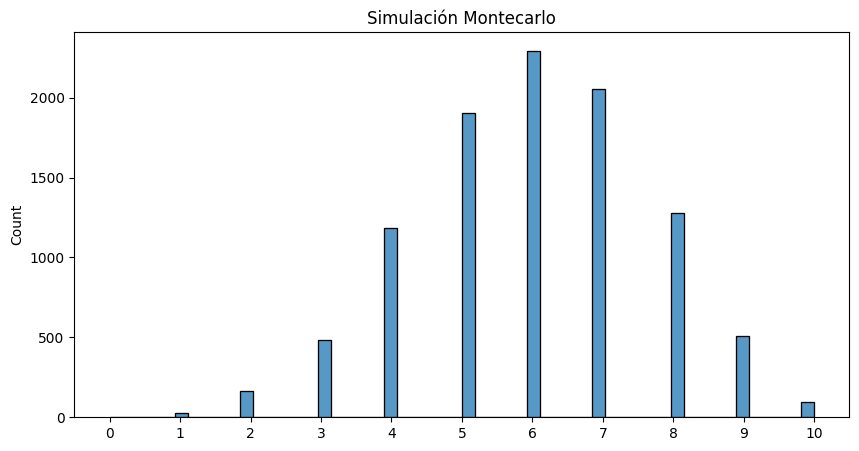

In [22]:
# crear gráfico, con las sumas de las 10.000 simulaciones
plt.figure(figsize=(10, 5))
plt.title('Simulación Montecarlo')
#plt.hist(total,20,color='b',label='Total',density=True) #con 20  clases fijas
sns.histplot(data=total)
plt.xticks(range(0,11))
plt.show()

El __TLC__ nos decía que, independientemente de la distribución de los datos originales (en nuestro caso la producción semanal), la distribución de las __medias de sus muestras__ tiende a una distribución normal. En este ejemplo, podemos concluir que la __suma de las muestras__ también tiende a tener la misma distribución. Vemos acá una aplicación práctica del __TLC__.



### <font color='blue'>**Paso 5**</font>

__Análisis__:

Alguien podría decir que para responder la pregunta solo bastaba con multiplicar la media ($\bar{x} = 1.2$ por la cantidad de semanas ($s=5$), lo cual nos daría una producción esperada de 6 unidades. Sin embargo, veamos la probabilidad que ocurra exactamente ese caso (6 unidades en las próximas 5 semanas).

In [23]:
sum(velocidad)/len(velocidad)

1.2

In [24]:
total.count(6)

2294

In [25]:
# Calcular la prob de entregar exactamente 6 unidades en 5 semanas (1,2*5)
prob6 = total.count(6) / m
print(f'Probabilidad de entregar 6 unidades = {prob6:4.2f}')

Probabilidad de entregar 6 unidades = 0.23


Como vemos, la probabilidad de obtener 6 unidades es __solo de un 23%__; la estrategia determinística es de alto riesgo (en este caro es  (1 - 0.22) = 78%).

Para evitar este riesgo, la proyección probabilística con Montecarlo nos invita a determinar una probabilidad de acierto para nuestro pronóstico en la cantidad de piezas a producir. De forma empírica, cuando usamos Montecarlo, buscaremos que la probabilidad de nuestro resultado tenga al menos un 85% de probabilidad de éxito.  Por lo tanto, calcularemos el perceltil 15 el cual representará el valor mínimo de producción para obtener un 85% de seguridad de ocurrencia.


In [26]:
# Es mejor calcular un valor que nos entregue un 85% de seguridad de cumplirse
# Aquí el valor de montecarlo que nos permite ver toda la distrucion de posibles resultados

p15= np.percentile(total, 15)
print('Percentil 15: ',p15)

#Por qué es mejor pensar probabilisticamente que deterministicamente?

Percentil 15:  4.0


Con un 85% de seguridad vamos a producir __al menos__ 4 piezas en las próximas 5 semanas. Puede que sean 5, 6, 7 o más, pero al menos serán 4.

Si la pedida del cliente es producir 8 piezas, vemos esa probabilidad.

In [27]:
prob8 = total.count(8) / m
print(f'Probabilidad de entregar 8 unidades = {prob8:4.2f}')

Probabilidad de entregar 8 unidades = 0.13


Por lo tanto, si este fuerra el caso, la decisión sería no postular al contrato o, en su defecto, ver formas de aumentar la capacidad de producción.

### <font color='green'>**Actividad 1**</font>

Con alguno de los casos de ejemplo que dimos:
* Datos de la cantidad de ventas de entradas para eventos (servicio online en entradas_vendidas/hora).
* Tenemos la velocidad de trabajo de un equipo ágil; la misma la medimos en Historias de usuario / sprint.
<br>o con<br>
* Un caso de uso propio de alguno de los alumnos del grupo.

1. Desarrolle una pregunta de negocio a responder.
2. Desarrolle una simulación de Montecarlo.
2. Considere que tiene una historia de 15 unidades de tiempo (horas o sprints de 3 semanas)


## Pregunta de Negocio
¿Cuál es la probabilidad de que el equipo complete al menos 10 historias de usuario en un sprint dado, considerando que su velocidad promedio es de 8 historias por sprint con una desviación estándar de 2 historias?

¿Cuál es la probabilidad de que el equipo complete al menos 10 historias de usuario en un sprint dado, considerando que su velocidad promedio es de 8 historias por sprint con una desviación estándar de 2 historias?
Probabilidad de completar al menos 10 historias en un sprint: 0.1622


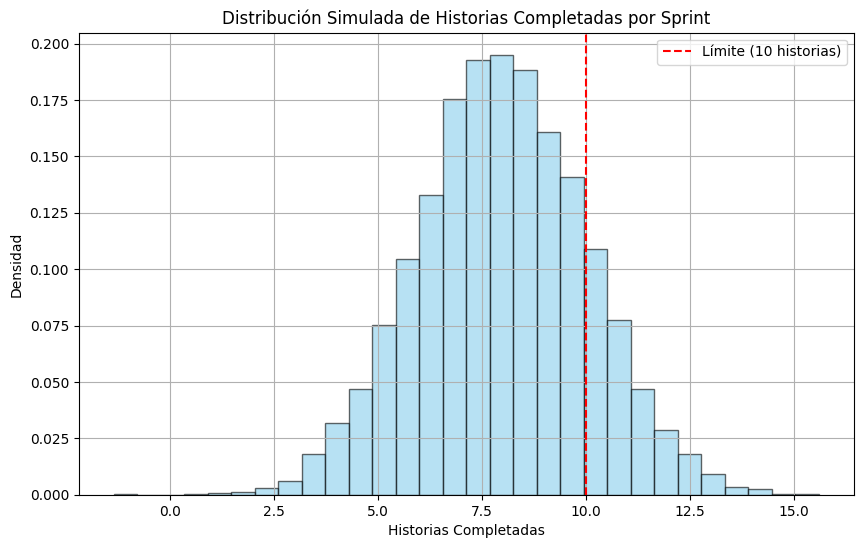

In [28]:
# Tu código aquí ...
# Pregunta
print("¿Cuál es la probabilidad de que el equipo complete al menos 10 historias de usuario en un sprint dado, considerando que su velocidad promedio es de 8 historias por sprint con una desviación estándar de 2 historias?")
# Parámetros
media = 8        # Historias de usuario promedio por sprint
desviacion_std = 2  # Desviación estándar
num_simulaciones = 10000  # Número de simulaciones

# Simulación de Montecarlo
resultados = np.random.normal(media, desviacion_std, num_simulaciones)

# Calcular la proporción que cumple con la condición (al menos 10 historias)
exitos = np.sum(resultados >= 10)
probabilidad = exitos / num_simulaciones

# Resultados
print(f"Probabilidad de completar al menos 10 historias en un sprint: {probabilidad:.4f}")

# Graficar la distribución de resultados
plt.figure(figsize=(10,6))
plt.hist(resultados, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
plt.axvline(10, color='red', linestyle='--', label='Límite (10 historias)')
plt.title('Distribución Simulada de Historias Completadas por Sprint')
plt.xlabel('Historias Completadas')
plt.ylabel('Densidad')
plt.legend()
plt.grid()
plt.show()



<font color='green'>Fin actividad 1</font>

## <font color='purple'>__Material adicional__</font>
Más ejemplos de simulacion de Monte Carlos

Github: [MONTE CARLO SIMULATION IN PYTHON AND R
](https://github.com/DiegoGamarra254/MONTECARLO-SIMULATION-IN-PYTHON-AND-R)

Este repositorio ofrece ejemplos básicos de simulación de Monte Carlo en Python y R, explicando el proceso paso a paso, desde la definición de parámetros hasta el análisis de resultados. Es un buen punto de partida para entender cómo implementar estas simulaciones en Python


### <font color='purple'>Fin material adicional </font>